In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import libraries
import os
import numpy as np
import subprocess
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import fixed, interact_manual
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths, peak_prominences
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Arial']
rcParams['svg.fonttype'] = 'none'

# Local module and scripts
from pyccapt.calibration.calibration import widgets as wd
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.tutorials.tutorials_helpers import helper_calibration
from pyccapt.calibration.tutorials.tutorials_helpers import helper_data_loader
from pyccapt.calibration.tutorials.tutorials_helpers import helper_temporal_crop
from pyccapt.calibration.tutorials.tutorials_helpers import helper_special_crop
from pyccapt.calibration.tutorials.tutorials_helpers import helper_t_0_tune
from pyccapt.calibration.tutorials.tutorials_helpers import helper_mc_plot
from pyccapt.calibration.tutorials.tutorials_helpers import helper_3d_reconstruction
from pyccapt.calibration.tutorials.tutorials_helpers import helper_ion_selection
from pyccapt.calibration.tutorials.tutorials_helpers import helper_visualization
from pyccapt.calibration.tutorials.tutorials_helpers import helper_ion_list
from pyccapt.calibration.calibration import share_variables

In [2]:
# create an object for selection of instrument specifications of the dataset
tdc, pulse_mode, flight_path_length, t0, max_mc, det_diam = wd.dataset_instrument_specification_selection()

# Display lists and comboboxes to selected instrument specifications
display(tdc, pulse_mode, flight_path_length, t0, max_mc)

Dropdown(description='Data mode:', options=('pyccapt', 'leap_epos', 'leap_pos', 'leap_apt', 'ato_v6'), value='…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=38.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

In [65]:
# create an instance of the Variables opject
variables = share_variables.Variables()
variables.pulse_mode = pulse_mode

In [85]:
variables = share_variables.Variables()
# dataset_path_12fs =  'D:/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
# dataset_path_12fs =  'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
# variables.result_data_name = '12fs'

# dataset_path_12ps = 'D:/pyccapt/tests/data/physics_experiment/LEAP_R56_09319_W_RT_powersweep/R56_09319-v01.h5'
dataset_path_12ps = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/LEAP_R56_09319_W_RT_powersweep/R56_09319-v01.h5'
variables.result_data_name = '12ps'

# dataset_path_12fs_power =  'D:/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
# variables.result_data_name = 'power_sweep_12fs'

# dataset_path_12ps_power = 'D:/pyccapt/tests/data/physics_experiment/LEAP_R56_09319_W_RT_powersweep/R56_09319-v01.h5'
# variables.result_data_name = 'power_sweep_12ps'


In [101]:
# exctract needed data from Pandas data frame as an numpy array


variables.result_data_path = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/results/MRP/' + variables.result_data_name + '/'
variables.result_path ='C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/results/MRP/' + variables.result_data_name + '/'

if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
# Create data farame out of hdf5 file dataset
variables.data = data_tools.load_data(dataset_path_12fs, tdc.value, mode='processed')
# data_12ps = data_tools.load_data(dataset_path_12ps, tdc.value, mode='processed')

# data_12fs_power = data_tools.load_data(dataset_path_12fs_power, tdc.value, mode='processed')
# data_12ps_power = data_tools.load_data(dataset_path_12ps_power, tdc.value, mode='processed')

data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
display(variables.data)

The maximum possible time of flight is: 11251


,x (nm),y (nm),z (nm),mc (Da),mc_uc (Da),high_voltage (V),pulse,t (ns),t_c (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp,start_counter
0,0.0,0.0,0.0,31.055637,32.711614,7502.297363,4338.635254,1209.0334,1290.271166,2.596390,-0.944264,0,1,24473
1,0.0,0.0,0.0,285.346074,300.865685,7502.297363,4338.635254,3613.1879,3839.640636,0.418139,-2.817090,2,1,24475
2,0.0,0.0,0.0,85.952736,89.929871,7502.297363,4338.635254,1989.6626,2123.397187,-1.650750,2.580620,1,1,24476
3,0.0,0.0,0.0,283.479624,298.633544,7502.297363,4338.635254,3586.8682,3827.180011,-0.741346,-1.753150,1,1,24477
4,0.0,0.0,0.0,45.028272,47.602763,7502.297363,4338.635254,1458.1421,1546.579332,-3.487050,0.084248,1,1,24478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715635,0.0,0.0,0.0,101.007077,105.440931,6096.536133,10792.778320,2377.6851,2298.880112,0.264085,2.394260,2,1,1143238
715636,0.0,0.0,0.0,92.013962,96.185879,6096.536133,10792.778320,2268.7300,2195.766479,0.295543,1.959480,1,1,1143239
715637,0.0,0.0,0.0,218.204749,228.091370,6096.536133,10792.778320,3478.6579,3362.157518,-1.251890,1.485290,1,1,1143240
715638,0.0,0.0,0.0,91.518834,96.312066,6096.536133,10792.778320,2266.8570,2189.946021,0.899990,-1.134980,1,1,1143241


In [102]:
import matplotlib as mpl

# Set agg.path.chunksize to prevent OverflowError
mpl.rcParams['agg.path.chunksize'] = 10000  # You can increase this if necessary

In [103]:
left_bound = 91.7
right_bound = 92.3

In [104]:
mask = (variables.mc < right_bound) & (variables.mc > left_bound)
aa = variables.mc[mask]

Bin size id: 0.1
Number of found peaks: 60
MRP 0.5: MRP: ***841.3337*** Peak Location: 91.9792, Peak Height: 0.9335, Left Bound: 91.9232, Left Height: 0.4729, Right Bound: 92.0325, Right Height: 0.4782


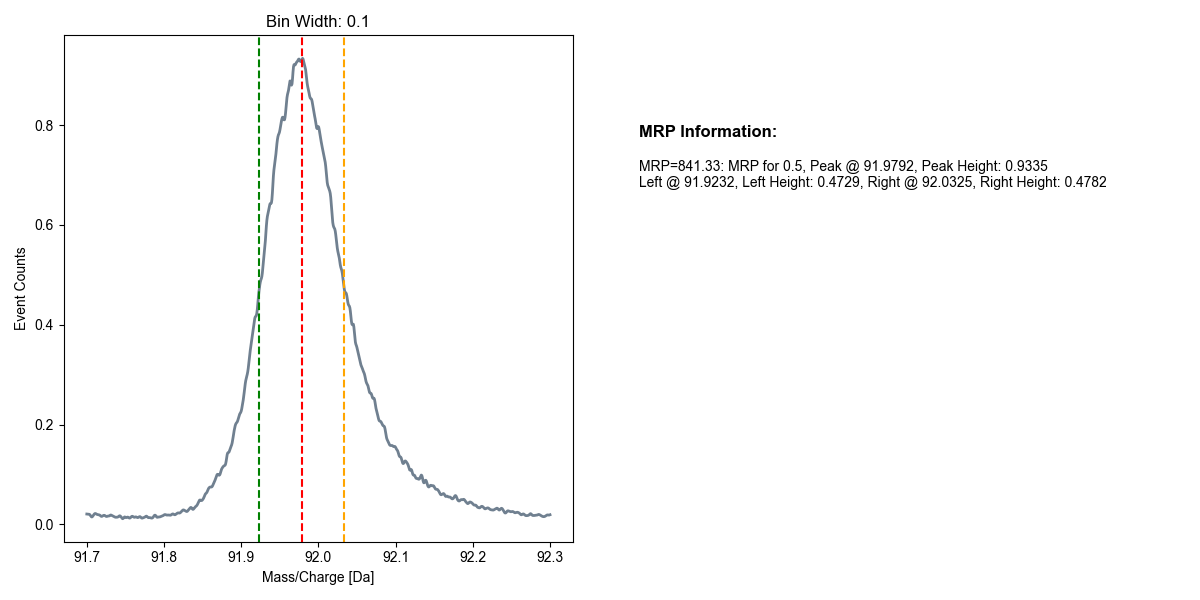

Bin size id: 0.01
Number of found peaks: 219
MRP 0.5: MRP: ***851.6828*** Peak Location: 91.9678, Peak Height: 0.7238, Left Bound: 91.9245, Left Height: 0.3673, Right Bound: 92.0325, Right Height: 0.3675


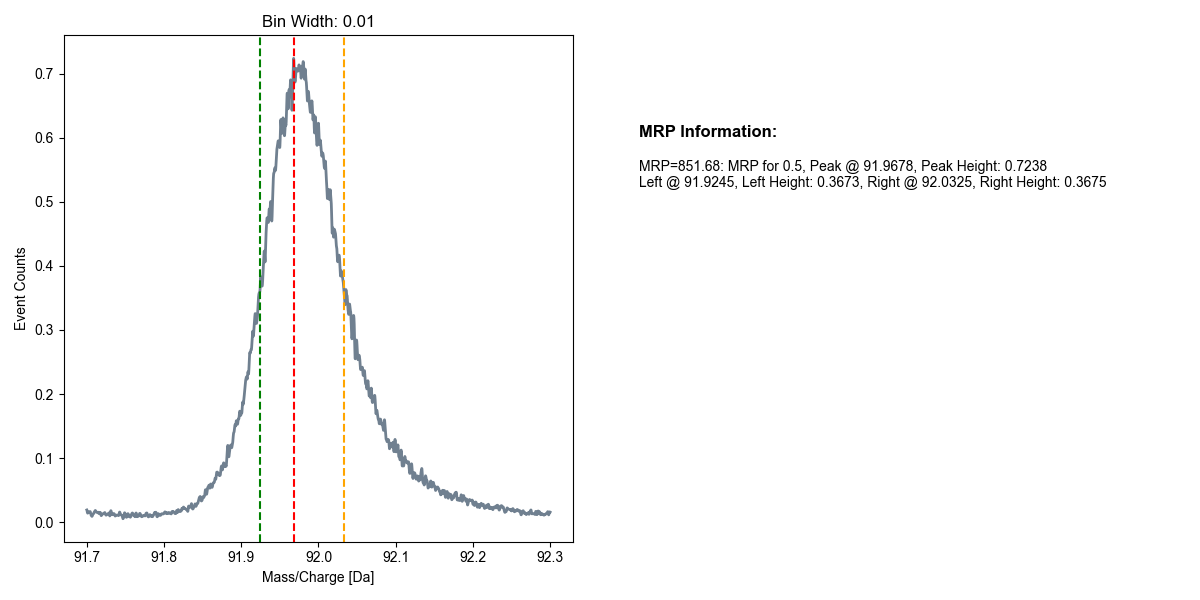

Bin size id: 0.001
Number of found peaks: 1476
MRP 0.5: MRP: ***1152.2879*** Peak Location: 91.9825, Peak Height: 0.4535, Left Bound: 91.9398, Left Height: 0.2275, Right Bound: 92.0196, Right Height: 0.2267


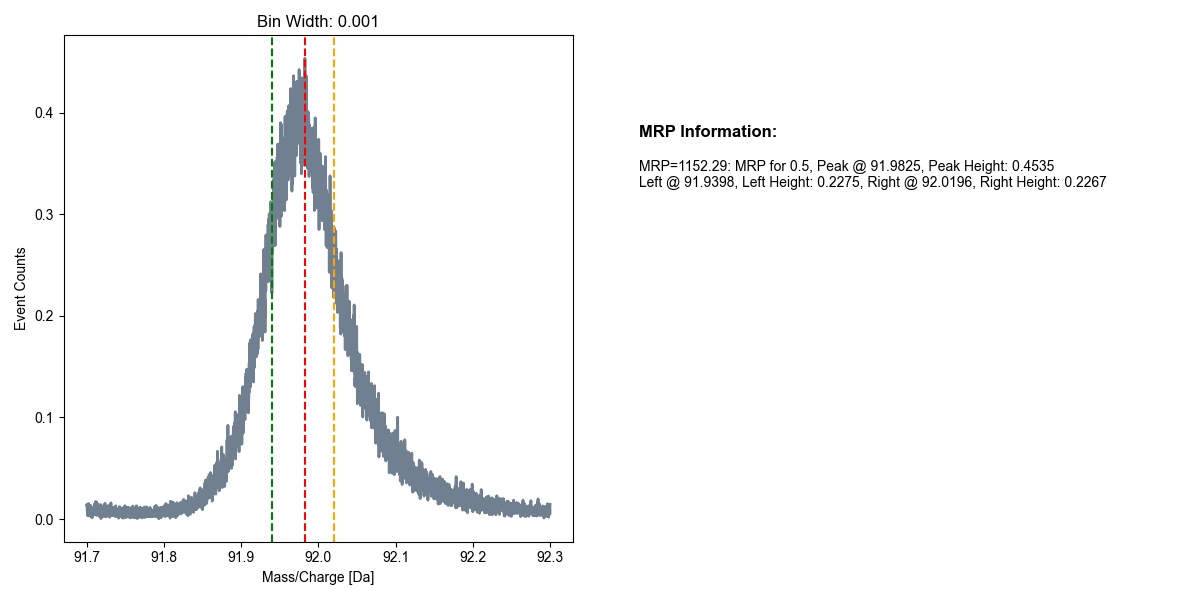

Bin size id: 0.0001
Number of found peaks: 5623
MRP 0.5: MRP: ***14088.2464*** Peak Location: 91.9825, Peak Height: 0.1862, Left Bound: 91.9820, Left Height: 0.0933, Right Bound: 91.9885, Right Height: 0.0929


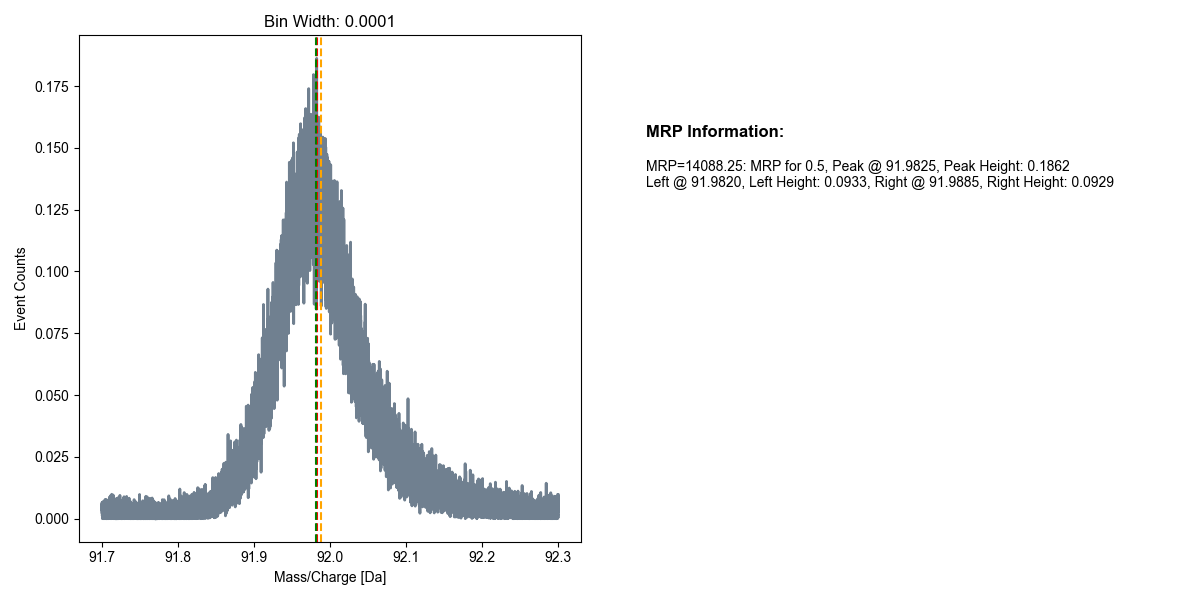

In [122]:
from scipy.ndimage import gaussian_filter1d
# Define the MRP range and bin size list
# mrp_range = [0.5, 0.1, 0.01]
mrp_range = [0.5]
bin_size_list = [0.1, 0.01, 0.001, 0.0001]
# bin_size_list = [0.1, 0.01]
sigma_list = [2, 8, 12, 32]


# Loop through each bin size in the bin size list
for index, bin_width in enumerate(bin_size_list):
    bins = np.linspace(np.min(aa), np.max(aa), round(np.max(aa) / bin_width))
    hist, bin_edges = np.histogram(aa, bins=bins)
    hist = hist / np.max(hist)
    
    # Get bin centers for line plot
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Apply Gaussian filter for smoothing
    hist = gaussian_filter1d(hist, sigma=sigma_list[index]) 

    # Create subplots: one for the histogram and one for the MRP information
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    # Plot the histogram using a line plot
    ax[0].plot(bin_centers, hist, color='slategray', linewidth=2, label='Line Histogram')
    ax[0].set_title(f'Bin Width: {bin_width}')
    ax[0].set_xlabel('Mass/Charge [Da]')
    ax[0].set_ylabel('Event Counts')  # Update label to reflect log scale
#     ax[0].set_yscale('log')  # Set y-axis to log scale for consistency with the original histogram

    # Create lists to store the combined MRP and bounds information for the legend
    bound_lines = []
    bound_labels = []
    print('Bin size id:', bin_width)

    # Loop through each MRP value in the range
    for mrp_s in mrp_range:
        mrp_r = 1 - mrp_s

        # Step 1: Find the peaks in the histogram
#         peaks, properties = find_peaks(hist, prominence=int(np.max(hist) * 0.8), distance=int(len(bins) / 2), height=0)
        peaks, properties = find_peaks(hist, height=0)
        print('Number of found peaks:', len(peaks))

        # Step 2: Calculate peak widths
        peak_width = peak_widths(hist, peaks, rel_height=mrp_r, prominence_data=None)

        # Step 3: Calculate peak prominences
        prominences = peak_prominences(hist, peaks, wlen=None)
        
        # Step 5: Calculate the peak height and 50% height level
        peak_height = coeffs[0]  # Amplitude of the fitted Gaussian
        half_height = peak_height * mrp_s

        # Step 6: Find the left and right bounds at 50% of the height
        left_bound = x_fit[np.where(y_fit < half_height)[0][0]]  # First index below 50%
        right_bound = x_fit[np.where(y_fit < half_height)[0][-1]]  # Last index below 50%

        # Step 4: Find the index of the peak with the maximum prominence
        if len(prominences[0]) > 0:
            index_peak_max = np.argmax(prominences[0])

            # Step 5: Calculate the MRP
            mrp_tmp = bin_edges[peaks][index_peak_max] / (bin_edges[round(peak_width[3][index_peak_max])] - 
                                                          bin_edges[round(peak_width[2][index_peak_max])])

            # Step 6: Print the peak location and its left and right bounds
            peak_loc = bin_edges[peaks][index_peak_max]
            left_bound = bin_edges[round(peak_width[2][index_peak_max])]
            right_bound = bin_edges[round(peak_width[3][index_peak_max])]

            # Calculate the heights at the peak, left bound, and right bound
            peak_height = hist[peaks][index_peak_max]
            left_height = hist[round(peak_width[2][index_peak_max])]
            right_height = hist[round(peak_width[3][index_peak_max])]

            print(f"MRP {mrp_s}: MRP: ***{mrp_tmp:.4f}*** Peak Location: {peak_loc:.4f}, Peak Height: {peak_height:.4f}, "
                  f"Left Bound: {left_bound:.4f}, Left Height: {left_height:.4f}, Right Bound: {right_bound:.4f}, Right Height: {right_height:.4f}")

            # Highlight the peak location, left, and right bounds on the plot
            ax[0].axvline(x=peak_loc, color='red', linestyle='--')
            left_line = ax[0].axvline(x=left_bound, color='green', linestyle='--')
            right_line = ax[0].axvline(x=right_bound, color='orange', linestyle='--')

            # Add a single combined legend for MRP, peak, left, and right bounds
            bound_lines.extend([left_line, right_line])
            bound_labels.append(
                f'MRP={mrp_tmp:.2f}: MRP for {mrp_s}, Peak @ {peak_loc:.4f}, Peak Height: {peak_height:.4f}\n'
                f'Left @ {left_bound:.4f}, Left Height: {left_height:.4f}, Right @ {right_bound:.4f}, Right Height: {right_height:.4f}'
            )

        else:
            print(f"MRP {mrp_s}: No peaks found for bin width {bin_width}")

        # Plot the MRP information on the second subplot
        ax[1].axis('off')  # Turn off the axis
        ax[1].text(0.1, 0.8, 'MRP Information:', fontsize=12, fontweight='bold')

        # Create a text box for each MRP and bounds
        for i, label in enumerate(bound_labels):
            ax[1].text(0.1, 0.7 - i * 0.15, label, fontsize=10)  # Adjust the y-position for better spacing
            
        # Draw the figure to ensure all elements are rendered before saving
        fig.canvas.draw()
        plt.tight_layout()
#         plt.savefig(variables.result_path + "/" + variables.result_data_name + "bin_%s_MRP_%s.png" %(bin_width, mrp_s), format="png", dpi=600)
#         plt.savefig(variables.result_path + "/" + variables.result_data_name + "%s_%s.svg" %(bin_width, mrp_s), format="svg", dpi=600)


    # Show the plot
    plt.show()

    print('====================================================')


Bin size id: 0.1
Number of found peaks: 1
********** 153.30335670494227 *****************
MRP 0.5: MRP: ***676.4692*** Peak Location: 92.0039, Peak Height: 0.8747, Left Bound: 91.9356, Left Height: 0.4372, Right Bound: 92.0716, Right Height: 0.4383


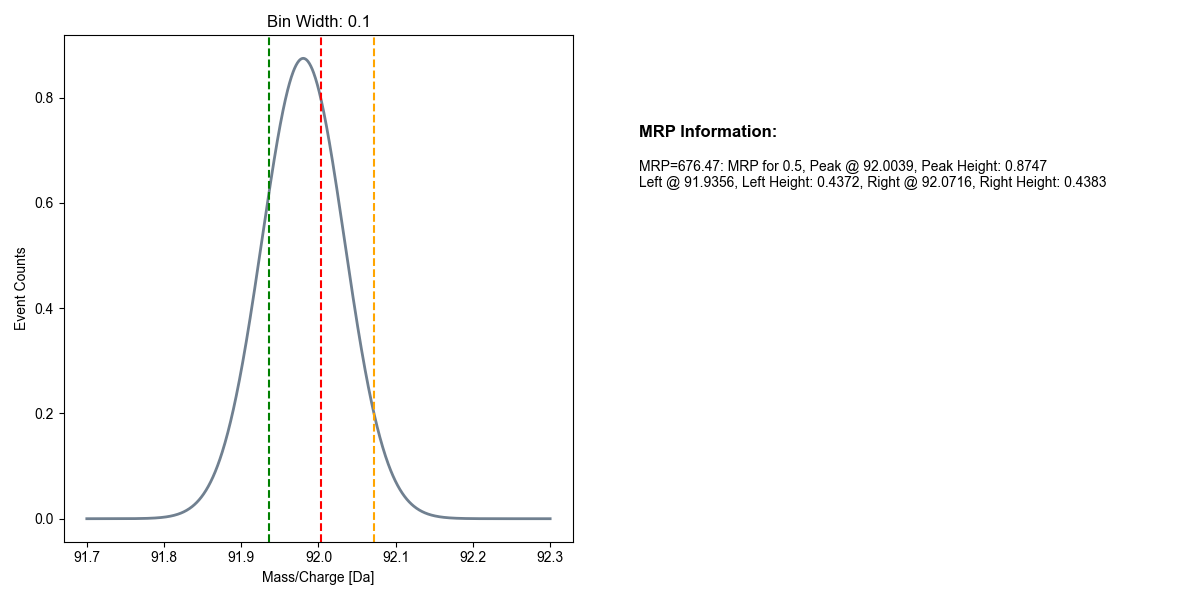

Bin size id: 0.01
Number of found peaks: 1
********** 153.3033574598861 *****************
MRP 0.5: MRP: ***6751.1635*** Peak Location: 91.7304, Peak Height: 0.6648, Left Bound: 91.7235, Left Height: 0.3323, Right Bound: 91.7371, Right Height: 0.3331


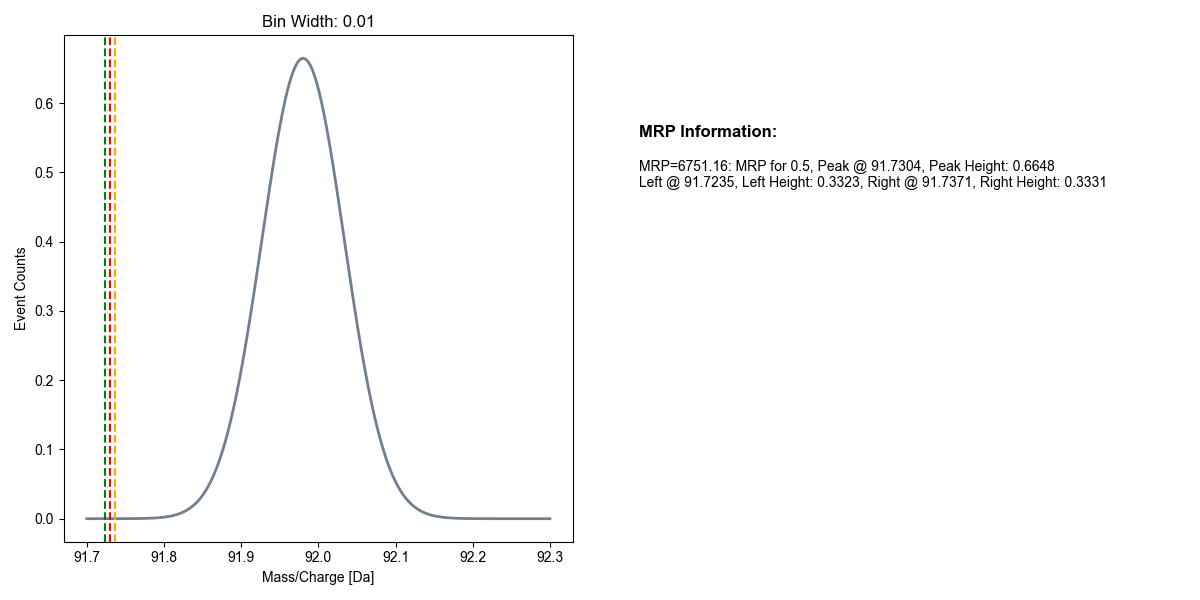

Bin size id: 0.001
Number of found peaks: 1
********** 153.30335784036205 *****************
MRP 0.5: MRP: ***67498.1064*** Peak Location: 91.7030, Peak Height: 0.3722, Left Bound: 91.7024, Left Height: 0.1860, Right Bound: 91.7037, Right Height: 0.1865


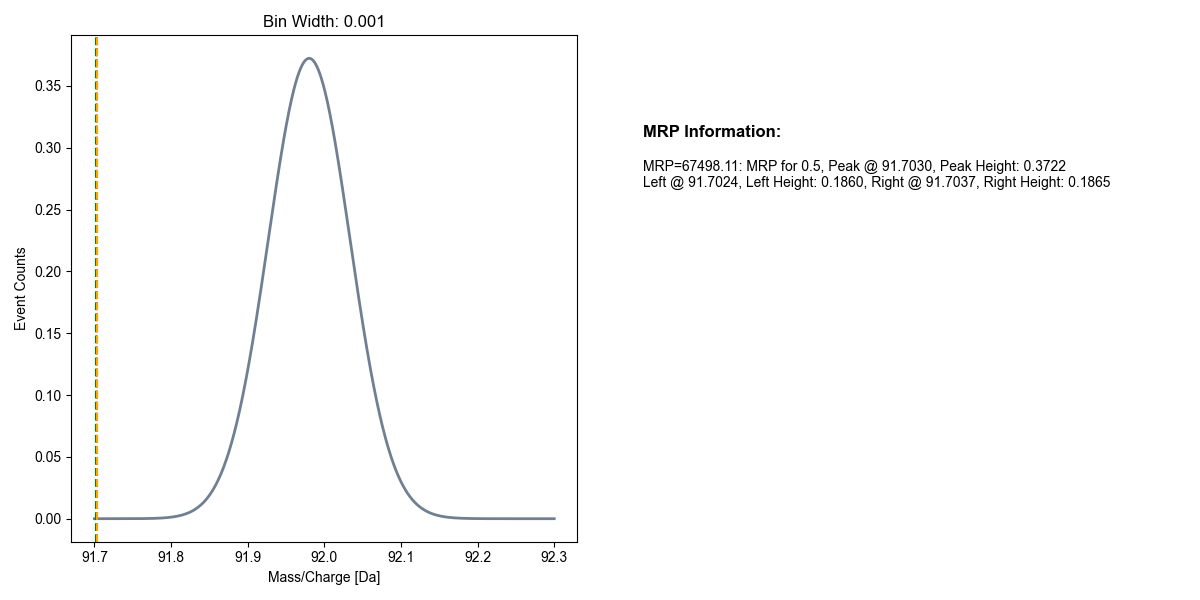

Bin size id: 0.0001
Number of found peaks: 1
********** 153.30335997565552 *****************
MRP 0.5: MRP: ***674967.5355*** Peak Location: 91.7003, Peak Height: 0.1241, Left Bound: 91.7002, Left Height: 0.0620, Right Bound: 91.7004, Right Height: 0.0622


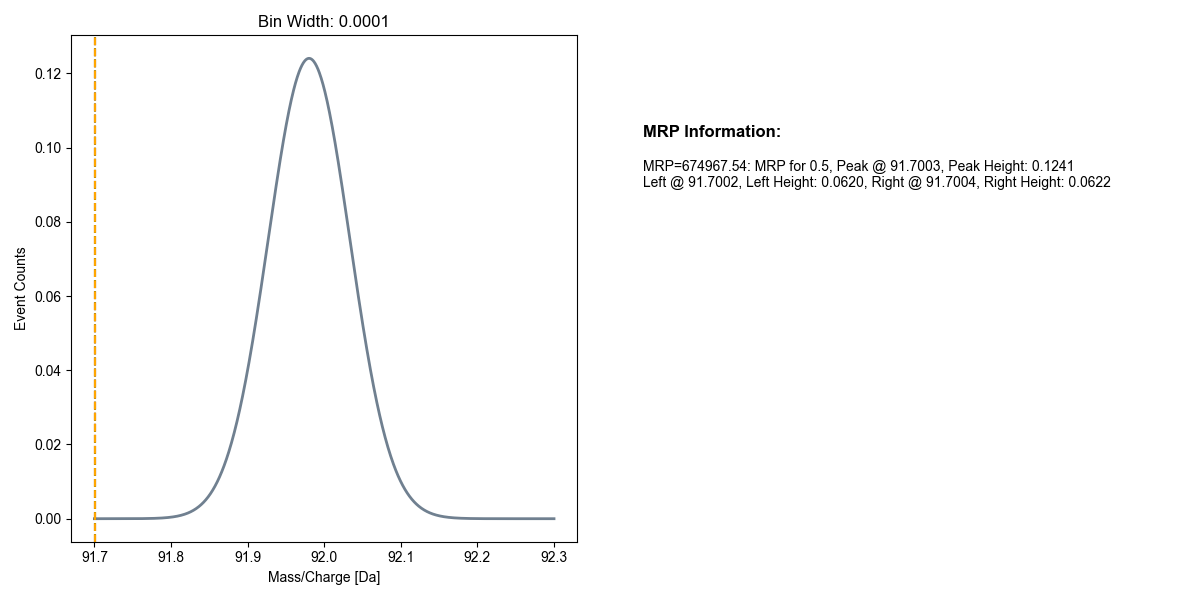

In [121]:
from scipy.ndimage import gaussian_filter1d
# Define the MRP range and bin size list
# mrp_range = [0.5, 0.1, 0.01]
mrp_range = [0.5]
bin_size_list = [0.1, 0.01, 0.001, 0.0001]
# bin_size_list = [0.1, 0.01]
sigma_list = [2, 8, 12, 32]

# Define a Gaussian function
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

# Loop through each bin size in the bin size list
for index, bin_width in enumerate(bin_size_list):
    bins = np.linspace(np.min(aa), np.max(aa), round(np.max(aa) / bin_width))
    hist, bin_edges = np.histogram(aa, bins=bins)
    hist = hist / np.max(hist)
    
    # Get bin centers for line plot
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
# Step 3: Fit a Gaussian to the histogram
    initial_guess = [1, np.mean(aa), np.std(aa)]  # Initial guess for amp, mean, and sigma
    coeffs, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

    # Step 4: Evaluate the fitted Gaussian
    x_fit = np.linspace(np.min(aa), np.max(aa), 1000)  # Finer range for smooth curve
    hist = gaussian(x_fit, *coeffs)
    
    # Apply Gaussian filter for smoothing
#     hist = gaussian_filter1d(hist, sigma=sigma_list[index]) 

    # Create subplots: one for the histogram and one for the MRP information
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    


    # Plot the histogram using a line plot
#     ax[0].plot(bin_centers, hist, color='slategray', linewidth=2, label='Line Histogram')
    ax[0].plot(x_fit, hist, color='slategray', linewidth=2, label='Line Histogram')
    ax[0].set_title(f'Bin Width: {bin_width}')
    ax[0].set_xlabel('Mass/Charge [Da]')
    ax[0].set_ylabel('Event Counts')  # Update label to reflect log scale
#     ax[0].set_yscale('log')  # Set y-axis to log scale for consistency with the original histogram

    # Create lists to store the combined MRP and bounds information for the legend
    bound_lines = []
    bound_labels = []
    print('Bin size id:', bin_width)

    # Loop through each MRP value in the range
    for mrp_s in mrp_range:
        mrp_r = 1 - mrp_s

        # Step 1: Find the peaks in the histogram
#         peaks, properties = find_peaks(hist, prominence=int(np.max(hist) * 0.8), distance=int(len(bins) / 2), height=0)
        peaks, properties = find_peaks(hist, height=0)
        print('Number of found peaks:', len(peaks))

        # Step 2: Calculate peak widths
        peak_width = peak_widths(hist, peaks, rel_height=mrp_r, prominence_data=None)

        # Step 3: Calculate peak prominences
        prominences = peak_prominences(hist, peaks, wlen=None)
        
        # Step 5: Calculate the peak height and 50% height level
        peak_height = coeffs[0]  # Amplitude of the fitted Gaussian
        half_height = peak_height * mrp_s

        # Step 6: Find the left and right bounds at 50% of the height
        left_bound = x_fit[np.where(y_fit < half_height)[0][0]]  # First index below 50%
        right_bound = x_fit[np.where(y_fit < half_height)[0][-1]]  # Last index below 50%

        # Step 7: Calculate the MRP
        peak_loc = coeffs[1]  # Mean of the fitted Gaussian
        mrp_m = peak_loc / (right_bound - left_bound)  # MRP calculation
        print('**********', mrp_m, '*****************')

        # Step 4: Find the index of the peak with the maximum prominence
        if len(prominences[0]) > 0:
            index_peak_max = np.argmax(prominences[0])

            # Step 5: Calculate the MRP
            mrp_tmp = bin_edges[peaks][index_peak_max] / (bin_edges[round(peak_width[3][index_peak_max])] - 
                                                          bin_edges[round(peak_width[2][index_peak_max])])

            # Step 6: Print the peak location and its left and right bounds
            peak_loc = bin_edges[peaks][index_peak_max]
            left_bound = bin_edges[round(peak_width[2][index_peak_max])]
            right_bound = bin_edges[round(peak_width[3][index_peak_max])]

            # Calculate the heights at the peak, left bound, and right bound
            peak_height = hist[peaks][index_peak_max]
            left_height = hist[round(peak_width[2][index_peak_max])]
            right_height = hist[round(peak_width[3][index_peak_max])]

            print(f"MRP {mrp_s}: MRP: ***{mrp_tmp:.4f}*** Peak Location: {peak_loc:.4f}, Peak Height: {peak_height:.4f}, "
                  f"Left Bound: {left_bound:.4f}, Left Height: {left_height:.4f}, Right Bound: {right_bound:.4f}, Right Height: {right_height:.4f}")

            # Highlight the peak location, left, and right bounds on the plot
            ax[0].axvline(x=peak_loc, color='red', linestyle='--')
            left_line = ax[0].axvline(x=left_bound, color='green', linestyle='--')
            right_line = ax[0].axvline(x=right_bound, color='orange', linestyle='--')

            # Add a single combined legend for MRP, peak, left, and right bounds
            bound_lines.extend([left_line, right_line])
            bound_labels.append(
                f'MRP={mrp_tmp:.2f}: MRP for {mrp_s}, Peak @ {peak_loc:.4f}, Peak Height: {peak_height:.4f}\n'
                f'Left @ {left_bound:.4f}, Left Height: {left_height:.4f}, Right @ {right_bound:.4f}, Right Height: {right_height:.4f}'
            )

        else:
            print(f"MRP {mrp_s}: No peaks found for bin width {bin_width}")

        # Plot the MRP information on the second subplot
        ax[1].axis('off')  # Turn off the axis
        ax[1].text(0.1, 0.8, 'MRP Information:', fontsize=12, fontweight='bold')

        # Create a text box for each MRP and bounds
        for i, label in enumerate(bound_labels):
            ax[1].text(0.1, 0.7 - i * 0.15, label, fontsize=10)  # Adjust the y-position for better spacing
            
        # Draw the figure to ensure all elements are rendered before saving
        fig.canvas.draw()
        plt.tight_layout()
#         plt.savefig(variables.result_path + "/" + variables.result_data_name + "bin_%s_MRP_%s.png" %(bin_width, mrp_s), format="png", dpi=600)
#         plt.savefig(variables.result_path + "/" + variables.result_data_name + "%s_%s.svg" %(bin_width, mrp_s), format="svg", dpi=600)


    # Show the plot
    plt.show()

    print('====================================================')


In [ ]:
# Define the MRP range and bin size list
mrp_range = [0.5, 0.1, 0.01]
bin_size_list = [0.1, 0.01]

# Loop through each bin size in the bin size list
for bin_width in bin_size_list:
    bins = np.linspace(np.min(aa), np.max(aa), round(np.max(aa) / bin_width))
    hist, bin_edges = np.histogram(aa, bins=bins)
    
    # Create subplots: one for the histogram and one for the MRP information
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    # Plot the histogram using matplotlib's hist
    ax[0].hist(aa, bins=bins, alpha=0.9, color='slategray', histtype='bar', edgecolor='k', log=True)  # Set y-axis to log
    ax[0].set_title(f'Bin Width: {bin_width}')
    ax[0].set_xlabel('Mass/Charge [Da]')
    ax[0].set_ylabel('Event Counts')  # Update label to reflect log scale
    ax[0].set_yscale('log')  # Set y-axis to log scale for consistency with the original histogram

    # Create lists to store the combined MRP and bounds information for the legend
    bound_lines = []
    bound_labels = []
    print('Bin size id:', bin_width)

    # Loop through each MRP value in the range
    for mrp_s in mrp_range:
        mrp_r = 1 - mrp_s

        # Step 1: Find the peaks in the histogram
        peaks, properties = find_peaks(hist, prominence=int(np.max(hist) * 0.8), distance=int(len(bins) / 2), height=0)
        print('Number of found peaks:', len(peaks))

        # Step 2: Calculate peak widths
        peak_width = peak_widths(hist, peaks, rel_height=mrp_r, prominence_data=None)

        # Step 3: Calculate peak prominences
        prominences = peak_prominences(hist, peaks, wlen=None)

        # Step 4: Find the index of the peak with the maximum prominence
        if len(prominences[0]) > 0:
            index_peak_max = np.argmax(prominences[0])

            # Step 5: Calculate the MRP
            mrp_tmp = bin_edges[peaks][index_peak_max] / (bin_edges[round(peak_width[3][index_peak_max])] -
                                                          bin_edges[round(peak_width[2][index_peak_max])])

            # Step 6: Print the peak location and its left and right bounds
            peak_loc = bin_edges[peaks][index_peak_max]
            left_bound = bin_edges[round(peak_width[2][index_peak_max])]
            right_bound = bin_edges[round(peak_width[3][index_peak_max])]

            # Calculate the heights at the peak, left bound, and right bound
            peak_height = hist[peaks][index_peak_max]
            left_height = hist[round(peak_width[2][index_peak_max])]
            right_height = hist[round(peak_width[3][index_peak_max])]

            print(f"MRP {mrp_s}: MRP: ***{mrp_tmp:.4f}*** Peak Location: {peak_loc:.4f}, Peak Height: {peak_height:.4f}, "
                  f"Left Bound: {left_bound:.4f}, Left Height: {left_height:.4f}, Right Bound: {right_bound:.4f}, Right Height: {right_height:.4f}")

            # Highlight the peak location, left, and right bounds on the plot (but no peak legend)
            ax[0].axvline(x=peak_loc, color='red', linestyle='--')
            left_line = ax[0].axvline(x=left_bound, color='green', linestyle='--')
            right_line = ax[0].axvline(x=right_bound, color='orange', linestyle='--')

            # Add a single combined legend for MRP, peak, left, and right bounds
            bound_lines.extend([left_line, right_line])
            bound_labels.append(
                f'MRP={mrp_tmp:.2f}: MRP for {mrp_s}, Peak @ {peak_loc:.4f}, Peak Height: {peak_height:.4f}\n'
                f'Left @ {left_bound:.4f}, Left Height: {left_height:.4f}, Right @ {right_bound:.4f}, Right Height: {right_height:.4f}'
            )
        else:
            print(f"MRP {mrp_s}: No peaks found for bin width {bin_width}")

    # Plot the MRP information on the second subplot
    ax[1].axis('off')  # Turn off the axis
    ax[1].text(0.1, 0.8, 'MRP Information:', fontsize=12, fontweight='bold')
    
    # Create a text box for each MRP and bounds
    for i, label in enumerate(bound_labels):
        ax[1].text(0.1, 0.7 - i * 0.15, label, fontsize=10)  # Adjust the y-position for better spacing

    # Adjust layout to make room for the legend on the right side
    plt.tight_layout()

    # Show the plot
    plt.show()

    print('====================================================')
